# 2D Burgers Equation DEMO code

This notebook demonstrates solving 1D Burgers Equation (spatial xy version) using Physics-Informed Neural Networks (PINNs).

In [1]:
import deepflow as df
print("Deepflow is runned on:", df.device) # to change to cpu use df.device = 'cpu'
df.manual_seed(69) # for reproducibility

Deepflow is runned on: cuda


## 1. Define Geometry Domain
Set up the computational domain

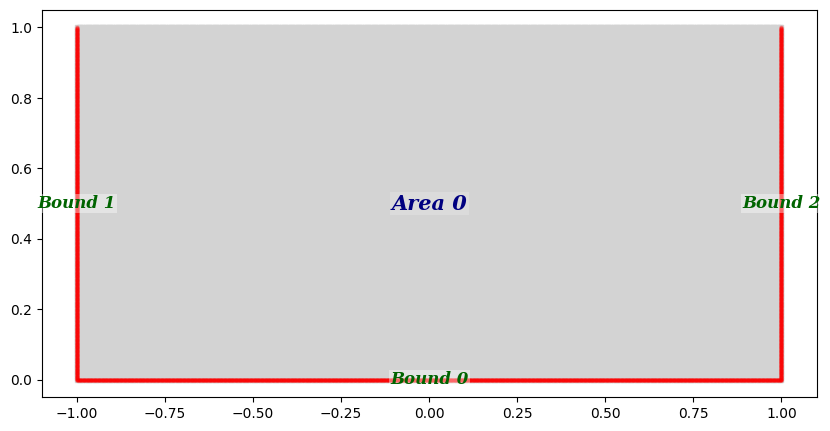

In [2]:
area = df.geometry.rectangle([-1, 1], [0, 1])
line_ic = df.geometry.line_horizontal(y=0, range_x=[-1,1])
line_bc1 = df.geometry.line_vertical(x=-1, range_y=[0,1])
line_bc2 = df.geometry.line_vertical(x=1, range_y=[0,1])
domain = df.domain(area.area_list, line_ic, line_bc1, line_bc2)
domain.show_setup()

## 2. Define Physics
Define the Burgers eq (spatial version) apply boundary conditions.

In [3]:
# Define PDE
from torch import sin, pi
domain.area_list[0].define_pde(df.pde.BurgersEquation1D(nu=0.01/pi))
domain.bound_list[0].define_bc({'u':['x', lambda x: -sin(pi * x)]})
domain.bound_list[1].define_bc({'u': 0})
domain.bound_list[2].define_bc({'u': 0})

### 2. Generate Training Data

Sample initial points for training. After sampling, Deepflow will automatically generate training datasets based on the defined physics.

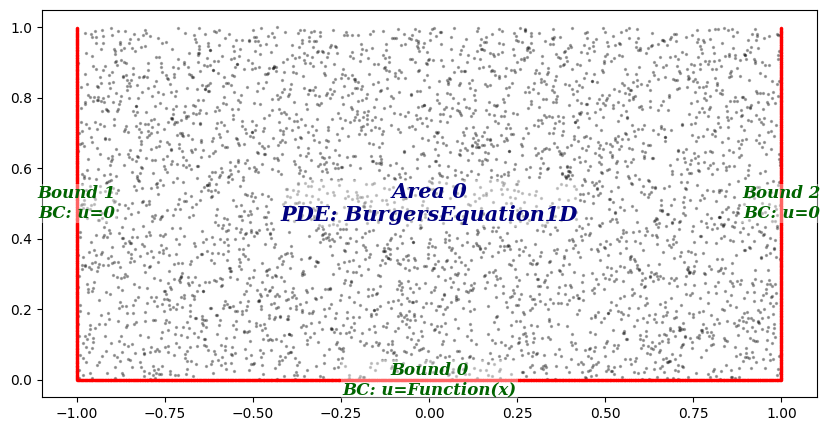

In [4]:
# Sample points: [Left, Bottom, Right, Top], [Interior]
domain.sampling_lhs([2000, 1000, 1000], [4000])
domain.show_coordinates(display_physics=True)

### 3. Train the Model

Define the resampling scheme during training. [R3](https://arxiv.org/abs/2207.02338) scheme is recommended.

In [5]:
def do_in_adam(epoch, model):
    if epoch % 500 == 0 and epoch > 0:
        domain.sampling_R3([2000, 1000, 1000], [4000])
        print(domain)
        
def do_in_lbfgs(epoch, model):
    if epoch % 100 == 0 and epoch > 0:
        domain.sampling_R3([2000, 1000, 1000], [4000])
        print(domain)

Train the model using Adam optimizer followed by L-BFGS optimizer.

In [6]:
model0 = df.PINN(input_vars=['x', 'y'], output_vars=['u'], width=16, length=4)

model1, model1_best = model0.train_adam(
    calc_loss = df.calc_loss_simple(domain),
    learning_rate=0.015,
    epochs=4000,
    do_between_epochs=do_in_adam)

Epoch: 1, total_loss: 0.63707, bc_loss: 0.63689, pde_loss: 0.00018
Epoch: 200, total_loss: 0.10304, bc_loss: 0.06050, pde_loss: 0.04253
Epoch: 400, total_loss: 0.12158, bc_loss: 0.06749, pde_loss: 0.05409
number of bound : ['0: 3026', '1: 1325', '2: 1399']
number of area : ['0: 5468']
Epoch: 600, total_loss: 0.05448, bc_loss: 0.03044, pde_loss: 0.02404
Epoch: 800, total_loss: 0.10144, bc_loss: 0.05830, pde_loss: 0.04314
number of bound : ['0: 3743', '1: 1914', '2: 2058']
number of area : ['0: 6758']
Epoch: 1000, total_loss: 0.03024, bc_loss: 0.01498, pde_loss: 0.01527
Epoch: 1200, total_loss: 0.02650, bc_loss: 0.01002, pde_loss: 0.01648
Epoch: 1400, total_loss: 0.01070, bc_loss: 0.00354, pde_loss: 0.00717
number of bound : ['0: 4443', '1: 2462', '2: 2443']
number of area : ['0: 7847']
Epoch: 1600, total_loss: 0.00889, bc_loss: 0.00335, pde_loss: 0.00555
Epoch: 1800, total_loss: 0.00480, bc_loss: 0.00092, pde_loss: 0.00389
number of bound : ['0: 5238', '1: 2834', '2: 2912']
number of ar

In [7]:
model2 = model1_best.train_lbfgs(calc_loss = df.calc_loss_simple(domain), epochs=1000, do_between_epochs=do_in_lbfgs)

Epoch: 3485, total_loss: 0.00093, bc_loss: 0.00016, pde_loss: 0.00077
Epoch: 3535, total_loss: 0.00006, bc_loss: 0.00001, pde_loss: 0.00005
number of bound : ['0: 9283', '1: 5057', '2: 5182']
number of area : ['0: 13442']
Epoch: 3585, total_loss: 0.00002, bc_loss: 0.00000, pde_loss: 0.00002
Epoch: 3635, total_loss: 0.00001, bc_loss: 0.00000, pde_loss: 0.00001
number of bound : ['0: 10048', '1: 5584', '2: 5601']
number of area : ['0: 14504']
Epoch: 3685, total_loss: 0.00001, bc_loss: 0.00000, pde_loss: 0.00001
Epoch: 3735, total_loss: 0.00001, bc_loss: 0.00000, pde_loss: 0.00001
number of bound : ['0: 10853', '1: 5988', '2: 5897']
number of area : ['0: 15507']
Epoch: 3785, total_loss: 0.00001, bc_loss: 0.00000, pde_loss: 0.00001
Epoch: 3835, total_loss: 0.00001, bc_loss: 0.00000, pde_loss: 0.00001
number of bound : ['0: 11557', '1: 6344', '2: 6330']
number of area : ['0: 16365']
Epoch: 3885, total_loss: 0.00001, bc_loss: 0.00000, pde_loss: 0.00001
Epoch: 3935, total_loss: 0.00001, bc_lo

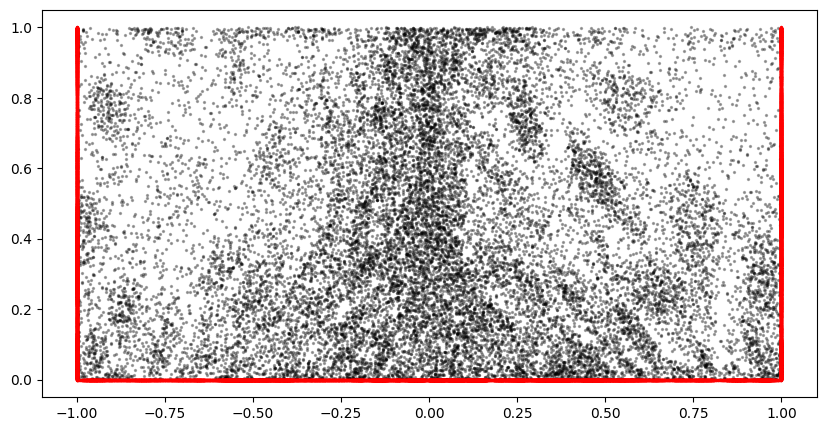

In [8]:
domain.show_coordinates(display_physics=False)

## 4. Visualization

In [9]:
# Evaluate the best model
prediction = domain.area_list[0].evaluate(model2)
# Sampling uniform points
prediction.sampling_area([300, 150])

### 4.1 Visualize PDE area

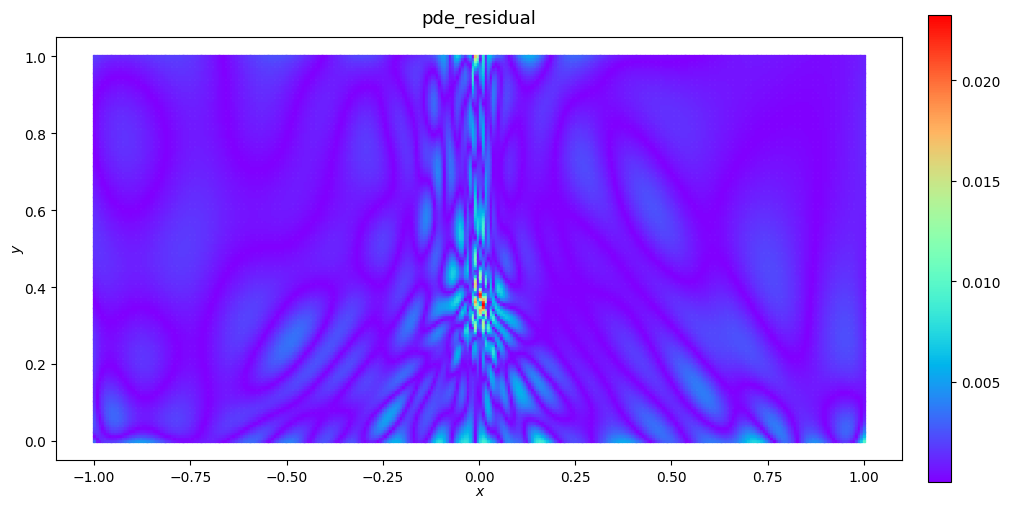

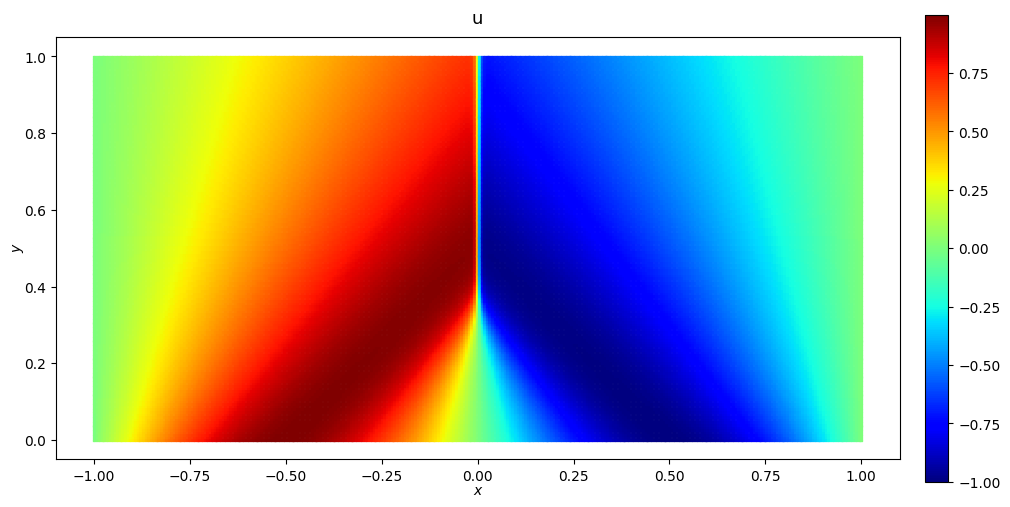

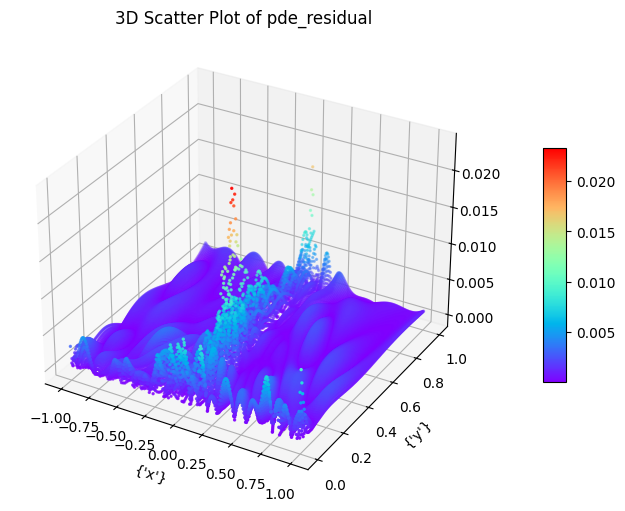

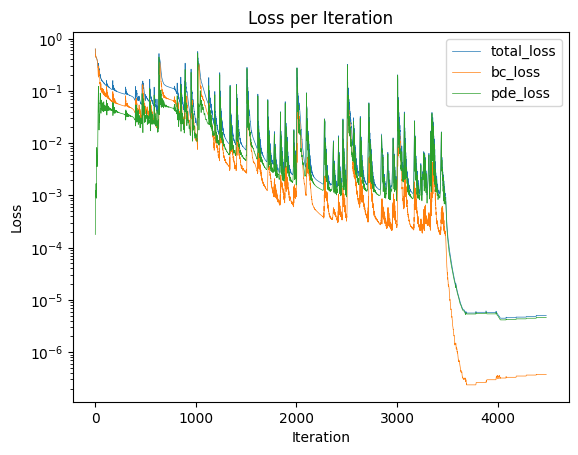

In [10]:
# Plot Velocity Field
_ = prediction.plot_color({'pde_residual':'rainbow'}, s=1.5)
_ = prediction.plot_color({'u':'jet'}, s=1.5)
_ = prediction.plot(z_axis={'pde_residual':'rainbow'})
_ = prediction.plot_loss_curve(log_scale=True)

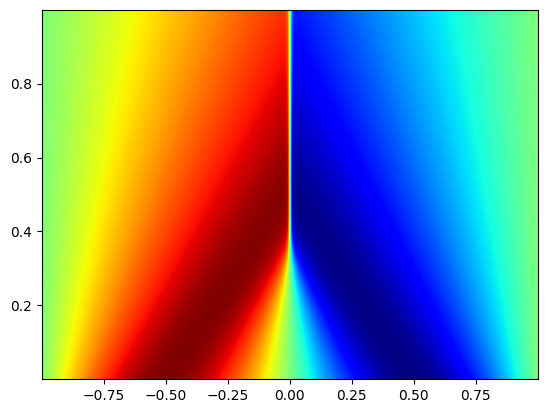

In [11]:
# If you want to plot manually using matplotlib
import matplotlib.pyplot as plt
_ = plt.tricontourf(prediction.data_dict['x'], prediction.data_dict['y'], prediction.data_dict['u'], levels=500, cmap='jet')

### 4.2 Visualize u at y = 0.75

Visualize the velocity field u along the horizontal line at y = 1.

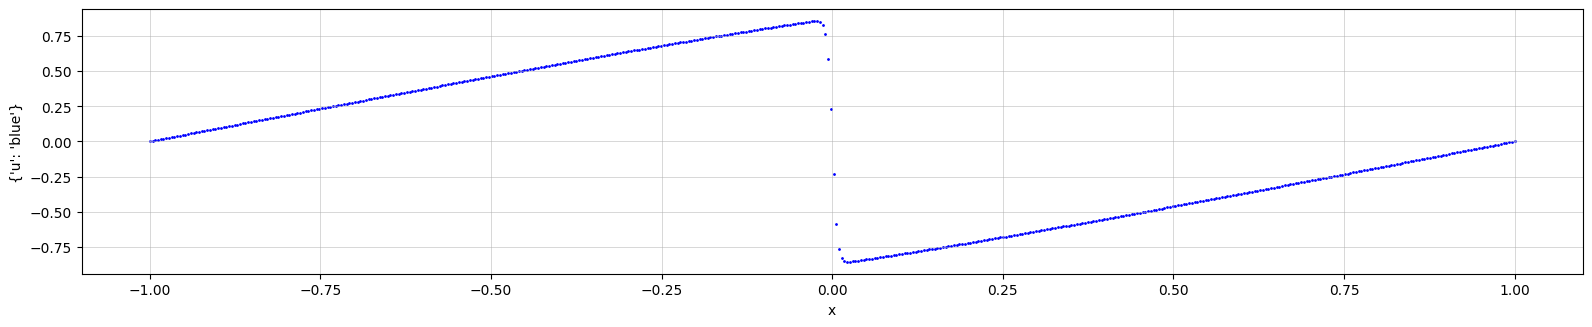

In [12]:
line = df.geometry.line_horizontal(y=0.75, range_x=[-1, 1])
prediction = line.evaluate(model2)
prediction.sampling_line(500)
_ = prediction.plot(y_axis={'u':'blue'})